# DSP Python Pipeline

OpenEO Web Editor Processes
1. Load Data
2. Preprocessing
3. Combining Datasets

Python Processes
1. EDA - Visualise spatial patterns of NDVI and pollutants, compute summary statistics
2. Statistical Analysis - Correlation analysis, regression modelling to predict vegetation health
3. Visualization of Results - Plots over time, spatial correlation maps, overlay results on maps for intuitive interpretation


In [3]:
# Import libraries
# Data Handling
import pandas as pd
import numpy as np
import geopandas

# Spatial Analysis
import rasterio
import shapely
import xarray

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import folium

# Machine Learning
import sklearn
import xgboost

# Statistical Analysis
import scipy
import statsmodels

### EDA
Load GeoTIFF files and inspect metadata using rasterio

In [46]:
# Load GeoTIFF
Sentinel2_Vondel = "Datasets/Sentinel2_Vondel/Sentinel2_Vondel_2021-01-01Z.tif"

# Open the GeoTIFF to inspect metadata
try:
    with rasterio.open(Sentinel2_Vondel) as src:
        metadata = {
            "width": src.width,
            "height": src.height,
            "count": src.count,  # Number of bands
            "crs": src.crs,  # Coordinate Reference System
            "transform": src.transform,  # Affine transformation
            "bounds": src.bounds,  # Spatial extent
            "dtype": src.dtypes,  # Data type of the raster
        }
except Exception as e:
    metadata = {"error": str(e)}

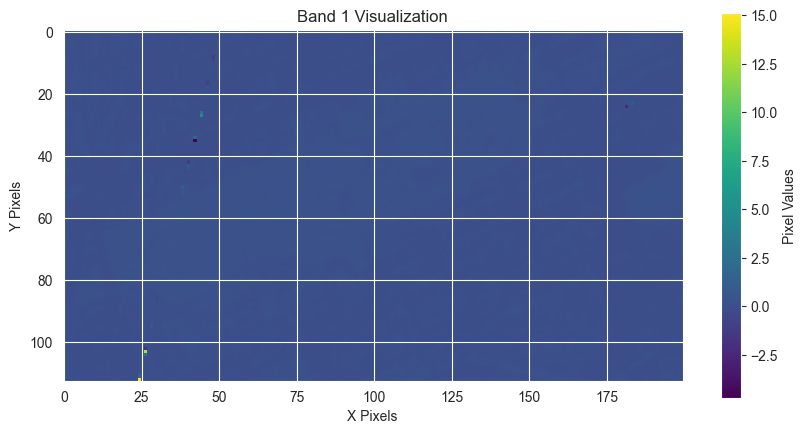

In [48]:
with rasterio.open(Sentinel2_Vondel) as src:
    band_1 = src.read(1)  #NDVI

band_1.shape

# Plot Band 1
plt.figure(figsize=(10, 5))
plt.title("Band 1 Visualization")
plt.imshow(band_1, cmap="viridis")
plt.colorbar(label="Pixel Values")
plt.xlabel("X Pixels")
plt.ylabel("Y Pixels")
plt.show()

In [39]:
# Dictionary to store statistics
raster_stats = {}

with rasterio.open(Sentinel2_Vondel) as src:
    for i in range(1, src.count + 1):  # Loop through bands
        band_data = src.read(i, masked=True)  # Read band data as a masked array to handle NoData values

        # Calculate statistics
        stats = {
            "min": float(np.min(band_data)),          # Minimum value
            "max": float(np.max(band_data)),          # Maximum value
            "mean": float(np.mean(band_data)),        # Mean
            "median": float(np.median(band_data)),    # Median
            "std": float(np.std(band_data)),          # Standard deviation
            "nodata": np.sum(band_data.mask)          # Count of NoData values
        }

        raster_stats[f"Band {i}"] = stats

# Display statistics
raster_stats

{'Band 1': {'min': -0.01113063097000122,
  'max': 0.38198167085647583,
  'mean': 0.13354887016433972,
  'median': 0.11914562433958054,
  'std': 0.06935781703148038,
  'nodata': np.int64(0)}}

In [53]:
# Load GeoTIFF
Sentinel5_Vondel = "Datasets/Old Data/Sentinel5_CO_Vondel.tiff"

# Open the GeoTIFF to inspect metadata
try:
    with rasterio.open(Sentinel5_Vondel) as src:
        metadata = {
            "width": src.width,
            "height": src.height,
            "count": src.count,  # Number of bands
            "crs": src.crs,  # Coordinate Reference System
            "transform": src.transform,  # Affine transformation
            "bounds": src.bounds,  # Spatial extent
            "dtype": src.dtypes,  # Data type of the raster
        }
except Exception as e:
    metadata = {"error": str(e)}

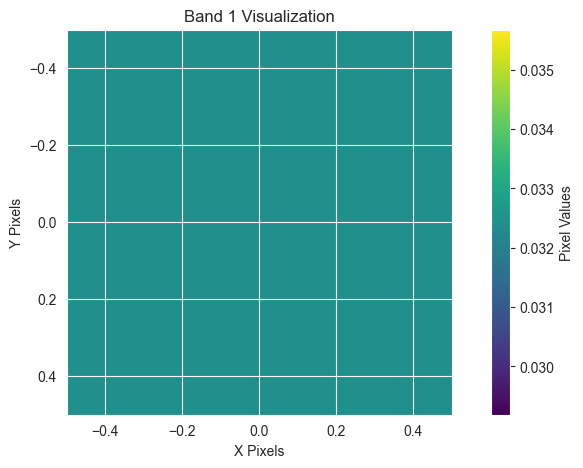

In [54]:
with rasterio.open(Sentinel5_Vondel) as src:
    band_1 = src.read(1)  #NDVI

# Plot Band 1
plt.figure(figsize=(10, 5))
plt.title("Band 1 Visualization")
plt.imshow(band_1, cmap="viridis")
plt.colorbar(label="Pixel Values")
plt.xlabel("X Pixels")
plt.ylabel("Y Pixels")
plt.show()

In [61]:
# Load GeoTIFF
Sentinel5and2Combined_Vondel = "Datasets/Old Data/CVIand5Combined.tif"

# Open the GeoTIFF to inspect metadata
try:
    with rasterio.open(Sentinel5and2Combined_Vondel) as src:
        metadata = {
            "width": src.width,
            "height": src.height,
            "count": src.count,  # Number of bands
            "crs": src.crs,  # Coordinate Reference System
            "transform": src.transform,  # Affine transformation
            "bounds": src.bounds,  # Spatial extent
            "dtype": src.dtypes,  # Data type of the raster
        }
except Exception as e:
    metadata = {"error": str(e)}

Visualise Data with matplotlib


In [68]:
with rasterio.open(Sentinel5and2Combined_Vondel) as src:
    band_1 = src.read(1) #NDVI
    band_2 = src.read(2) #Atmospheric CO Levels aggregated temporally
    test, test2 = src.xy

# Plot Band 1
plt.figure(figsize=(10, 5))
plt.title("Band 1 Visualization")
plt.imshow(band_1, cmap="viridis")
plt.colorbar(label="Pixel Values")
plt.xlabel("X Pixels")
plt.ylabel("Y Pixels")
plt.show()

# Plot Band 2
plt.figure(figsize=(10, 5))
plt.title("Band 2 Visualization")
plt.imshow(band_2, cmap="viridis")
plt.colorbar(label="Pixel Values")
plt.xlabel("X Pixels")
plt.ylabel("Y Pixels")
plt.show()

TypeError: cannot unpack non-iterable method object

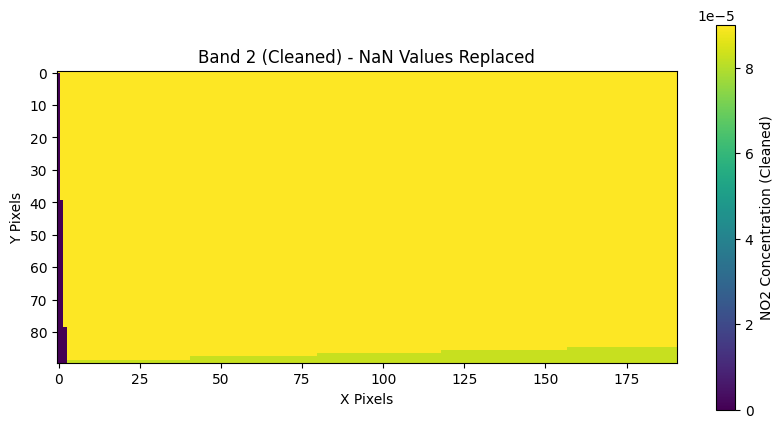

{'NaNs Before Cleanup': np.int64(150), 'NaNs After Cleanup': np.int64(0)}

In [22]:
# Mask NaN values in Band 2
band_2_cleaned = np.nan_to_num(band_2, nan=0)  # Replace NaNs with 0

# Visualize the cleaned Band 2
plt.figure(figsize=(10, 5))
plt.title("Band 2 (Cleaned) - NaN Values Replaced")
plt.imshow(band_2_cleaned, cmap="viridis")
plt.colorbar(label="NO2 Concentration (Cleaned)")
plt.xlabel("X Pixels")
plt.ylabel("Y Pixels")
plt.show()

# Count the number of NaNs before and after cleanup
nan_count_before = np.sum(np.isnan(band_2))
nan_count_after = np.sum(np.isnan(band_2_cleaned))

{"NaNs Before Cleanup": nan_count_before, "NaNs After Cleanup": nan_count_after}

Analyze Data Dimensions and Get Some Stats


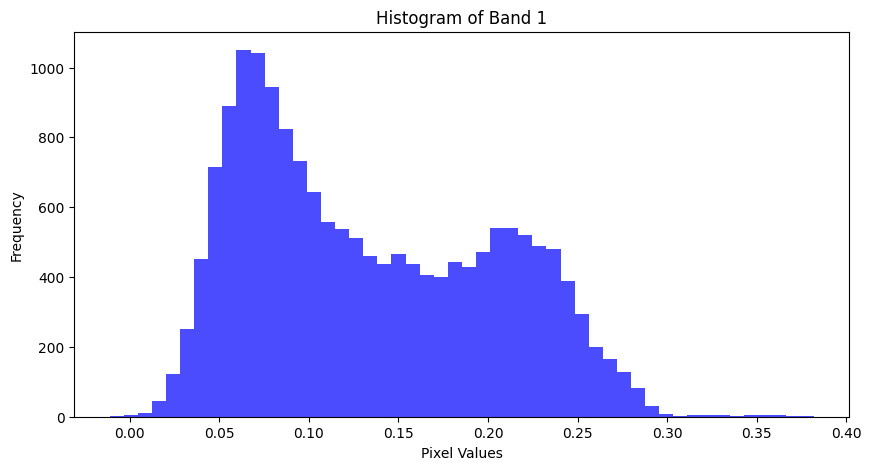

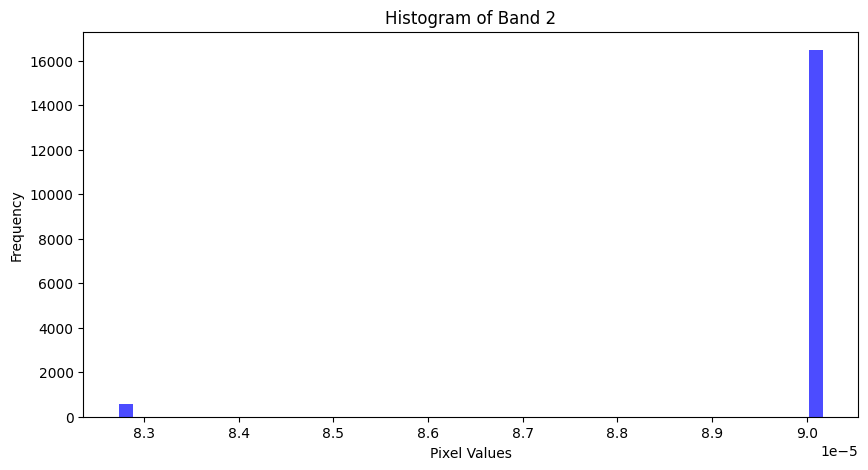

{'Band 1': {'min': -0.01113063097000122,
  'max': 0.38198167085647583,
  'mean': 0.13354887016433972,
  'median': 0.11914562433958054,
  'std': 0.06935781703148038,
  'nodata': np.int64(0)},
 'Band 2': {'min': 8.273291314253584e-05,
  'max': 9.01723324204795e-05,
  'mean': 8.992958516582077e-05,
  'median': nan,
  'std': 1.3217159899673015e-06,
  'nodata': np.int64(150)}}

In [26]:
# Dictionary to store statistics
raster_stats = {}

with rasterio.open(Sentinel5and2Combined_Vondel) as src:
    for i in range(1, src.count + 1):  # Loop through bands
        band_data = src.read(i, masked=True)  # Read band data as a masked array to handle NoData values

        # Calculate statistics
        stats = {
            "min": float(np.min(band_data)),          # Minimum value
            "max": float(np.max(band_data)),          # Maximum value
            "mean": float(np.mean(band_data)),        # Mean
            "median": float(np.median(band_data)),    # Median
            "std": float(np.std(band_data)),          # Standard deviation
            "nodata": np.sum(band_data.mask)          # Count of NoData values
        }

        raster_stats[f"Band {i}"] = stats

        # Plot histogram
        plt.figure(figsize=(10, 5))
        plt.hist(band_data.compressed(), bins=50, color='blue', alpha=0.7)
        plt.title(f"Histogram of Band {i}")
        plt.xlabel("Pixel Values")
        plt.ylabel("Frequency")
        plt.show()

# Display statistics
raster_stats

In [45]:
import openeo

# Connect to the backend
connection = openeo.connect("https://earthengine.openeo.org")